# Results Section: EU vs US Cookie Consent Analysis

This notebook produces the values for the **Results** section of our paper. It compares cookie consent interfaces between EU and US traffic using Consent Observatory scraper data.

**Data sources**: `tranco_germany.json` (EU) and `tranco_us.json` (US).

## 1. Setup and Data Loading

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.parse import urlparse

# data paths
DATA_DIR = Path(r'../data/')
EXAMPLES_DIR = DATA_DIR / 'examples'
OUTPUT_DIR = DATA_DIR / 'output'

# plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10
COLORS = {'EU': '#003399', 'US': '#B22234'}

print("Setup complete.")

Setup complete.


### 1.1 Load Data

In [2]:
def load_records_from_json_file(json_path):
    records = []
    with open(json_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                records.append(json.loads(line))
    return records

# --- Load data ---
all_eu_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco_germany.json')
all_us_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco_us.json')

print(f"All EU records: {len(all_eu_records)}")
print(f"All US records: {len(all_us_records)}")

All EU records: 780
All US records: 770


### 1.2 Common Websites Filter

Restrict the dataset to websites that retrieved succesfully in both EU and US crawls. This ensures a fair comparison between regions.

In [3]:
# find common websites and filter
eu_urls = {r.get('url') for r in all_eu_records}
us_urls = {r.get('url') for r in all_us_records}
common_urls = eu_urls & us_urls

eu_records = [r for r in all_eu_records if r.get('url') in common_urls]
us_records = [r for r in all_us_records if r.get('url') in common_urls]

n_eu_before, n_us_before = len(all_eu_records), len(all_us_records)
n_eu_after, n_us_after = len(eu_records), len(us_records)

# table: dataset length change after common-websites filter
dataset_change = pd.DataFrame({
    'Location': ['EU', 'US'],
    'Before (records)': [n_eu_before, n_us_before],
    'After (records)': [n_eu_after, n_us_after],
    'Dropped': [n_eu_before - n_eu_after, n_us_before - n_us_after],
})

print(f"Common websites: {len(common_urls)}")
dataset_change

Common websites: 744


,Location,Before (records),After (records),Dropped
0,EU,780,744,36
1,US,770,744,26


In [4]:
# --- Inspect JSON structure ---

# let's select the first record
sample = eu_records[0]

print("Top-level keys:", list(sample.keys()))
print("data gatherers:", list((sample.get('data')).keys()))
print(*("--------" for i in range(10)))

# gatherers = ['ScreenshotGatherer','DOMGatherer', 'CookieGatherer',
#             'WordBoxGatherer', 'IABJSGatherer', 'EventListenerGatherer',
#             'ButtonGatherer', 'NormalizedWordButtonGatherer',
#             'VisibilityAnalyzer', 'CheckboxGatherer', 'CMPGatherer']
gatherers = list((sample.get('data')).keys())

for gatherer in gatherers:
    gatherer_data = (sample.get('data')).get(gatherer)
    if not gatherer_data:
        print(f"***{gatherer} is empty")
        continue
    gatherer_keys = list(gatherer_data.keys())
    print(f"--> {gatherer}: {gatherer_keys}")
    for key in gatherer_keys:
        print(f"    --> {key}")

Top-level keys: ['time', 'url', 'requestStrategy', 'data']
data gatherers: ['ScreenshotGatherer', 'DOMGatherer', 'CookieGatherer', 'WordBoxGatherer', 'IABJSGatherer', 'EventListenerGatherer', 'ButtonGatherer', 'NormalizedWordButtonGatherer', 'VisibilityAnalyzer', 'CheckboxGatherer', 'CMPGatherer']
-------- -------- -------- -------- -------- -------- -------- -------- -------- --------
--> ScreenshotGatherer: ['onDomContentLoaded', 'onPageWait']
    --> onDomContentLoaded
    --> onPageWait
--> DOMGatherer: ['dom']
    --> dom
--> CookieGatherer: ['cookies']
    --> cookies
--> WordBoxGatherer: ['hits', 'potentialAnchors', 'filteredAnchors', 'filteredFrames', 'detections']
    --> hits
    --> potentialAnchors
    --> filteredAnchors
    --> filteredFrames
    --> detections
--> IABJSGatherer: ['tcfapiDetected', 'pingResult']
    --> tcfapiDetected
    --> pingResult
--> EventListenerGatherer: ['detections', 'detectionsArray']
    --> detections
    --> detectionsArray
--> ButtonGather

## 2. JSON Schema (from Consent Observatory Gatherers)

Each record has `url`, `time`, `requestStrategy`, and `data` with gatherer outputs:

| Gatherer | Output structure | Key fields |
|----------|------------------|------------|
| **CookieGatherer** | `{ cookies: [...] }` | `name`, `value`, `domain`, `path`, `secure`, `httpOnly`, `session`, `sameSite`, `expires`, `size`, `priority`, `sameParty`, `sourceScheme`, `sourcePort` |
| **NormalizedWordButtonGatherer** | `{ detections, detectionsArray }` | `text`, `normalized`, `category`, `distance`, `visibilityAnalysis`, `popup`, `element` |
| **ButtonGatherer** | `{ detections, detectionsArray }` | `text`, `html`, `visibilityAnalysis`, `score`, `scoreDetails` |
| **EventListenerGatherer** | `{ detections, detectionsArray }` | `text`, `html`, `confidence`, `visibilityAnalysis`, `score`, `scoreDetails` |
| **CMPGatherer** | `{ CMPs: [...] }` | `CMP_name`, `matchedPattern`, `matchingElement`, `matchingAttribute`, `matchingValue` |
| **CheckboxGatherer** | `{ detections, detectionsArray }` | `status` (checked), `disabled`, `html` |
| **WordBoxGatherer** | `{ hits: [...], detections, ... }` | `html`, `matches` (text, triggers), `negativeMatches`, `path`, `visibilityAnalysis`, `potentialAnchors` |
| **IABJSGatherer** | `{ tcfapiDetected, pingResult }` | `tcfapiDetected`, `pingResult` |
| **ScreenshotGatherer** | `{ onDomContentLoaded, onPageWait }` | Base64 encoded image strings |
| **DOMGatherer** | `{ dom }` | `dom` (raw HTML string) |
| **VisibilityAnalyzer** | `null` | N/A |

**NormalizedWordButtonGatherer category** (numeric, from word-corpus):

| Accept | Reject | Settings | Accept Selection | Other |
|--------|--------|----------|------------------|-------|
| 1 | 2 | 3 | 4 | 5 |

## 3. Cookie Analysis

### 3.1 Extract CookieGatherer Data

In [5]:
def extract_cookies_to_csv(website_data_list, output_filename):
    # Define the column headers for the CSV
    headers = [
        'website_url', 'cookie_name', 'value', 'domain', 'path', 'expires', 
        'size', 'httpOnly', 'secure', 'session', 'sameSite', 
        'priority', 'sameParty', 'sourceScheme', 'sourcePort'
    ]
    
    # Open the file and set up the writer
    with open(output_filename, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers, delimiter=';')
        writer.writeheader()
        
        # Iterate through each website's data object
        for site_data in website_data_list:
            url = site_data.get('url', 'Unknown URL')
            
            data_block = site_data.get('data', {})
            cookie_gatherer = data_block.get('CookieGatherer', {})
            cookies = cookie_gatherer.get('cookies', [])
            
            # Loop through each cookie in the list and write it to the CSV
            for cookie in cookies:
                row = {
                    'website_url': url,
                    'cookie_name': cookie.get('name', ''),
                    'value': cookie.get('value', ''),
                    'domain': cookie.get('domain', ''),
                    'path': cookie.get('path', ''),
                    'expires': cookie.get('expires', ''),
                    'size': cookie.get('size', ''),
                    'httpOnly': cookie.get('httpOnly', ''),
                    'secure': cookie.get('secure', ''),
                    'session': cookie.get('session', ''),
                    'sameSite': cookie.get('sameSite', ''), 
                    'priority': cookie.get('priority', ''),
                    'sameParty': cookie.get('sameParty', ''),
                    'sourceScheme': cookie.get('sourceScheme', ''),
                    'sourcePort': cookie.get('sourcePort', '')
                }
                writer.writerow(row)

# extract cookies to csv
extract_cookies_to_csv(eu_records, OUTPUT_DIR / 'eu_cookies.csv')
extract_cookies_to_csv(us_records, OUTPUT_DIR / 'us_cookies.csv')
print(f"Successfully extracted cookies from EU and US records. Files saved under {OUTPUT_DIR}")

Successfully extracted cookies from EU and US records. Files saved under ..\data\output


In [6]:
df_eu_cookies = pd.read_csv(OUTPUT_DIR / 'eu_cookies.csv', sep=';')
df_us_cookies = pd.read_csv(OUTPUT_DIR / 'us_cookies.csv', sep=';')

# let's check the cookies dataframe for EU
df_eu_cookies.head()

,website_url,cookie_name,value,domain,path,expires,size,httpOnly,secure,session,sameSite,priority,sameParty,sourceScheme,sourcePort
0,https://wikipedia.org,WMF-Last-Access,21-Feb-2026,wikipedia.org,/,1.774441e+09,26,True,True,False,NaN,Medium,False,Secure,443
1,https://wikipedia.org,WMF-Last-Access-Global,21-Feb-2026,.wikipedia.org,/,1.774441e+09,33,True,True,False,NaN,Medium,False,Secure,443
2,https://wikipedia.org,GeoIP,DE:BY:Munich:48.19:11.48:v4,.wikipedia.org,/,-1.000000e+00,32,False,True,True,NaN,Medium,False,Secure,443
3,https://wikipedia.org,NetworkProbeLimit,0.001,wikipedia.org,/,1.771705e+09,22,False,True,False,NaN,Medium,False,Secure,443
4,https://wikipedia.org,WMF-Last-Access,21-Feb-2026,www.wikipedia.org,/,1.774509e+09,26,True,True,False,NaN,Medium,False,Secure,443


### 3.2 Filter to Common Websites

Compare what websites have CookieGatherer data for both locations, then restrict the analysis to common websites only.

In [7]:
# get unique websites from both dataframes
eu_websites = set(df_eu_cookies['website_url'])
us_websites = set(df_us_cookies['website_url'])

# websites in EU but NOT in US
eu_only_websites = eu_websites - us_websites
print(f"Number of websites ONLY in EU dataset: {len(eu_only_websites)}")
print(eu_only_websites)

# websites in US but NOT in EU
us_only_websites = us_websites - eu_websites
print(f"Number of websites ONLY in US dataset: {len(us_only_websites)}")
print(us_only_websites)

common_websites = eu_websites & us_websites

# Update DataFrames to keep only rows where the URL is in our common set
df_eu_cookies = df_eu_cookies[df_eu_cookies['website_url'].isin(common_websites)]
df_us_cookies = df_us_cookies[df_us_cookies['website_url'].isin(common_websites)]

# Print the new row counts to verify it worked
print(f"Updated EU cookies dataset size: {len(df_eu_cookies)} cookies")
print(f"Updated US cookies dataset size: {len(df_us_cookies)} cookies")


Number of websites ONLY in EU dataset: 5
{'https://myntra.com', 'https://android.com', 'https://chordtela.com', 'https://cookiedatabase.org', 'https://uidai.gov.in'}
Number of websites ONLY in US dataset: 12
{'https://ekstrabladet.dk', 'https://tapad.com', 'https://nesine.com', 'https://latimes.com', 'https://mozilla.com', 'https://adblockplus.org', 'https://firefox.com', 'https://stripe.com', 'https://fb.com', 'https://t.co', 'https://a-mo.net', 'https://amazon.es'}
Updated EU cookies dataset size: 9041 cookies
Updated US cookies dataset size: 26157 cookies


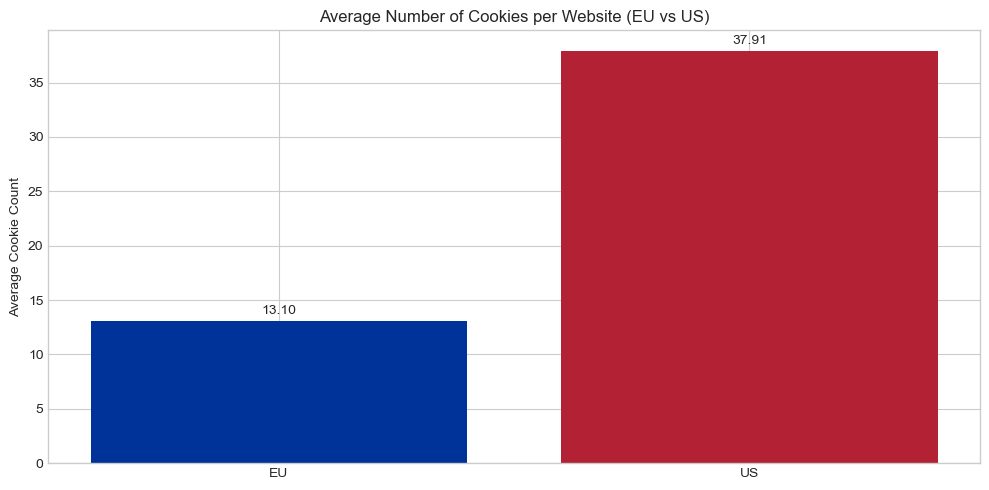

In [8]:
# calculate average cookies per website
eu_avg = len(df_eu_cookies) / df_eu_cookies['website_url'].nunique()
us_avg = len(df_us_cookies) / df_us_cookies['website_url'].nunique()

avg_cookies = [eu_avg, us_avg]
regions = ['EU', 'US']

fig, ax = plt.subplots()
bars = ax.bar(regions, avg_cookies, color=[COLORS['EU'], COLORS['US']])

ax.set_title('Average Number of Cookies per Website (EU vs US)')
ax.set_ylabel('Average Cookie Count')

for bar in bars:
    height = bar.get_height()
    # format the height to show 2 decimal places (e.g., 14.53)
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# display the plot
plt.tight_layout()
plt.show()

### 3.3 Top 10 Websites with Most Cookies

In [9]:
# calculate the base counts
eu_counts = df_eu_cookies['website_url'].value_counts().reset_index()
eu_counts.columns = ['website', 'count_eu']

us_counts = df_us_cookies['website_url'].value_counts().reset_index()
us_counts.columns = ['website', 'count_us']

# create the MOST cookies table
# get top 10, then reset index so they align perfectly
eu_most = eu_counts.head(10)[['website', 'count_eu']].reset_index(drop=True)
# eu_least = eu_counts.tail(10)[['website', 'count_eu']].reset_index(drop=True)     ->>> we should remove these probably because it is not interesting + websites are problematic lol
us_most = us_counts.head(10)[['website', 'count_us']].reset_index(drop=True)
# us_least = us_counts.tail(10)[['website', 'count_us']].reset_index(drop=True)     ->>> read above

eu_most.columns = ['EU Most', 'Count']
# eu_least.columns = ['EU Least', 'Count']
us_most.columns = ['US Most', 'Count']
# us_least.columns = ['US Least', 'Count']

# combine horizontally
most_cookies_table = pd.concat([eu_most, us_most], axis=1)
most_cookies_table.index = range(1, 11)
most_cookies_table.index.name = 'Rank'


display(most_cookies_table)

,EU Most,Count,US Most,Count
Rank,,,,
1,https://ficbook.net,159,https://jagran.com,484
2,https://avito.ru,127,https://clarin.com,452
3,https://livejournal.com,109,https://genius.com,381
4,https://carsensor.net,90,https://merkur.de,373
5,https://macys.com,87,https://huffpost.com,369
6,https://mlb.com,84,https://livehindustan.com,366
7,https://rakuten.co.jp,77,https://huffingtonpost.com,361
8,https://hbr.org,70,https://independent.co.uk,357
9,https://pendo.io,68,https://kooora.com,356


### 3.4 Cookie Difference Comparison (EU vs US)

In [10]:
# merge all counts, fill missing with 0
merged = pd.merge(eu_counts, us_counts, on='website', how='outer').fillna(0)

# calculate where EU has more cookies
eu_more = merged[merged['count_eu'] > merged['count_us']].copy()
eu_more['diff'] = (eu_more['count_eu'] - eu_more['count_us']).astype(int)
eu_more_top = eu_more.sort_values(by='diff', ascending=False)[['website', 'diff']].head(10).reset_index(drop=True)
eu_more_top.columns = ['EU Has More Cookies', 'Diff']

# calculate where US has more
us_more = merged[merged['count_us'] > merged['count_eu']].copy()
us_more['diff'] = (us_more['count_us'] - us_more['count_eu']).astype(int)
us_more_top = us_more.sort_values(by='diff', ascending=False)[['website', 'diff']].head(10).reset_index(drop=True)
us_more_top.columns = ['US Has More Cookies', 'Diff']

# combine differences
diff_table = pd.concat([eu_more_top, us_more_top], axis=1)
diff_table.index = range(1, 11)
diff_table.index.name = 'Rank'

display(diff_table)

,EU Has More Cookies,Diff,US Has More Cookies,Diff
Rank,,,,
1,https://meraki.com,33,https://jagran.com,472
2,https://mydramalist.com,31,https://clarin.com,420
3,https://livejournal.com,28,https://genius.com,371
4,https://xnxx.health,27,https://merkur.de,365
5,https://savefrom.net,20,https://huffpost.com,360
6,https://amazon.ca,19,https://huffingtonpost.com,353
7,https://sportradar.com,19,https://kooora.com,346
8,https://amazon.com.au,18,https://britannica.com,341
9,https://ya.ru,18,https://livehindustan.com,333


### 3.5 First-Party vs Third-Party Cookies

Distribution of first-party vs third-party cookies for EU and US traffic.

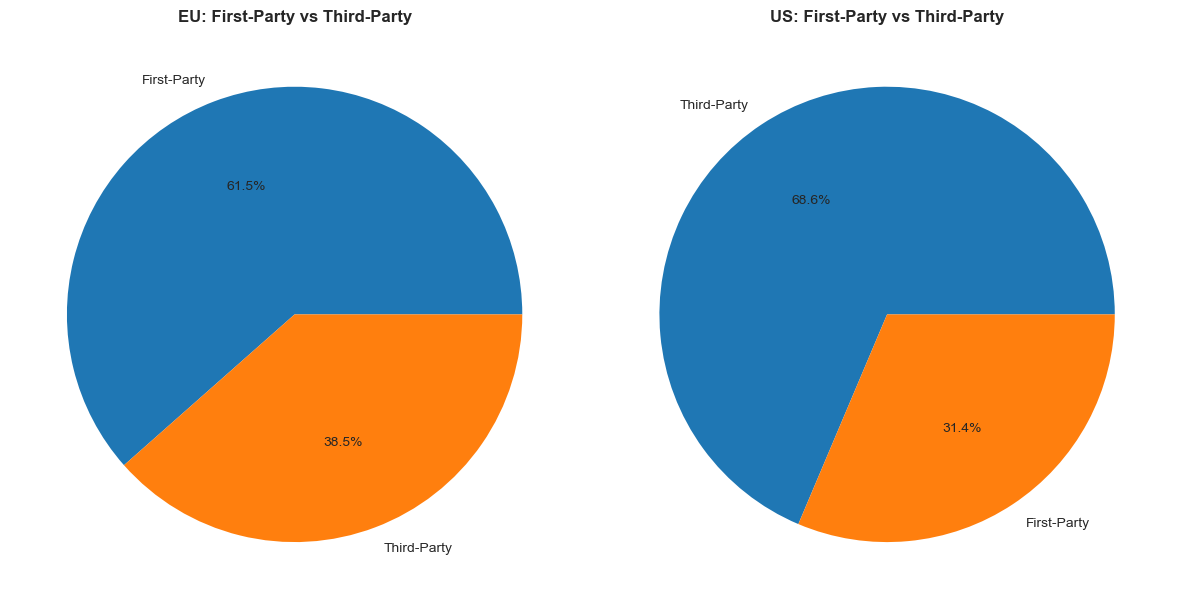

In [11]:
def categorize_party(row):
    # extract the hostname from the website_url and remove 'www.' if present
    url_host = str(urlparse(row['website_url']).hostname).removeprefix('www.')
    
    # clean the cookie domain by removing leading dots AND 'www.' if present
    cookie_domain = str(row['domain']).lstrip('.').removeprefix('www.')
    
    # if it's an exact match OR a valid subdomain match, it's First-Party
    if url_host == cookie_domain or url_host.endswith('.' + cookie_domain):
        return 'First-Party'
    else:
        return 'Third-Party'

# this creates a new column called 'party', first-party/third-party
df_eu_cookies['party'] = df_eu_cookies.apply(categorize_party, axis=1)
df_us_cookies['party'] = df_us_cookies.apply(categorize_party, axis=1)

# count the occurrences
eu_party_counts = df_eu_cookies['party'].value_counts()
us_party_counts = df_us_cookies['party'].value_counts()

# plot pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot EU
axes[0].pie(eu_party_counts, 
            labels=eu_party_counts.index, 
            autopct='%1.1f%%')
axes[0].set_title('EU: First-Party vs Third-Party', fontweight='bold')
# Plot US
axes[1].pie(us_party_counts, 
            labels=us_party_counts.index, 
            autopct='%1.1f%%')
axes[1].set_title('US: First-Party vs Third-Party', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Consent Button Analysis

### 4.1 Extract Normalized Buttons

In [12]:
def extract_normalized_buttons_to_csv(website_data_list, output_filename='website_buttons.csv'):
    # Define the column headers, including flattened visibility analysis fields
    headers = [
        'website_url', 'text', 'normalized', 'element', 'category', 'distance', 'popup',
        'vis_color', 'vis_backgroundColor', 'vis_fontSize', 'vis_fontWeight', 
        'vis_clickability', 'vis_score'
    ]
    
    with open(output_filename, mode='w', newline='', encoding='utf-8') as csv_file:
        # Using semicolon delimiter for European Excel compatibility
        writer = csv.DictWriter(csv_file, fieldnames=headers, delimiter=';')
        writer.writeheader()
        
        for site_data in website_data_list:
            url = site_data.get('url', 'Unknown URL')
            
            # Safely navigate to the NormalizedWordButtonGatherer array
            data_block = site_data.get('data', {})
            button_gatherer = data_block.get('NormalizedWordButtonGatherer', {})
            detections_array = button_gatherer.get('detectionsArray', [])
            
            # Loop through each detected button
            for detection in detections_array:
                # The visibility data is nested, so we pull it out first
                vis_analysis = detection.get('visibilityAnalysis', {})
                
                row = {
                    'website_url': url,
                    'text': detection.get('text', ''),
                    'normalized': detection.get('normalized', ''),
                    'element': detection.get('element', ''),
                    'category': detection.get('category', ''),
                    'distance': detection.get('distance', ''),
                    'popup': detection.get('popup', ''),
                    
                    # Flattened visibility metrics
                    'vis_color': vis_analysis.get('color', ''),
                    'vis_backgroundColor': vis_analysis.get('backgroundColor', ''),
                    'vis_fontSize': vis_analysis.get('fontSize', ''),
                    'vis_fontWeight': vis_analysis.get('fontWeight', ''),
                    'vis_clickability': vis_analysis.get('clickability', ''),
                    'vis_score': vis_analysis.get('score', '')
                }
                writer.writerow(row)

# extract noramlized buttons to csv                
extract_normalized_buttons_to_csv(eu_records, OUTPUT_DIR / 'eu_normalized_buttons.csv')
extract_normalized_buttons_to_csv(us_records, OUTPUT_DIR / 'us_normalized_buttons.csv')
print(f"Successfully extracted normalized buttons from EU and US records. Files saved under {OUTPUT_DIR}")

Successfully extracted normalized buttons from EU and US records. Files saved under ..\data\output


In [13]:
df_eu_normalized_buttons = pd.read_csv(OUTPUT_DIR / 'eu_normalized_buttons.csv', sep=';')
df_us_normalized_buttons = pd.read_csv(OUTPUT_DIR / 'us_normalized_buttons.csv', sep=';')

# let's check the normalized buttons dataframe for EU
df_eu_normalized_buttons.head()

,website_url,text,normalized,element,category,distance,popup,vis_color,vis_backgroundColor,vis_fontSize,vis_fontWeight,vis_clickability,vis_score
0,https://instagram.com,nb,ne,"<option value=""nb"">Norsk</option>",2,1,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
1,https://instagram.com,nl,ne,"<option value=""nl"">Nederlands</option>",2,1,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
2,https://instagram.com,ne,ne,"<option value=""ne"">नेपाली</option>",2,0,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
3,https://netflix.com,Learn more,learnmore→,"<button id=""onetrust-pc-btn-handler"" aria-labe...",3,1,0,"rgb(51, 51, 51)","rgb(255, 255, 255)",13.008px,600.0,1.0,0.418980
4,https://netflix.com,Reject,reject,"<button id=""onetrust-reject-all-handler"">Rejec...",2,0,0,"rgb(255, 255, 255)","rgb(229, 9, 20)",13.008px,600.0,1.0,1.428698


### 4.2 Button Existence Matrix

In [14]:
# create a function to build the 1/0 matrix (to show if a specific button category exists or not)
def get_button_existence(df):
    # crosstab counts occurrences, but we just want to know if it's > 0
    matrix = pd.crosstab(df['website_url'], df['category'])
    
    # Convert counts to 1 (Exists) or 0 (Does not exist)
    existence_df = (matrix > 0).astype(int)
    return existence_df

# Apply to your button dataframes (replace with your actual dataframe names if different)
eu_button_exist = get_button_existence(df_eu_normalized_buttons)
us_button_exist = get_button_existence(df_us_normalized_buttons)

print("EU Button Existence Matrix (Preview)")
display(eu_button_exist.head())

EU Button Existence Matrix (Preview)


category,1,2,3,4,5
website_url,,,,,
https://3bmeteo.com,1,0,1,0,0
https://3lift.com,1,1,1,1,0
https://aajtak.in,1,0,1,0,0
https://abc.es,1,0,1,0,1
https://actu.fr,1,1,1,0,0


### 4.3 Button Presence by Category

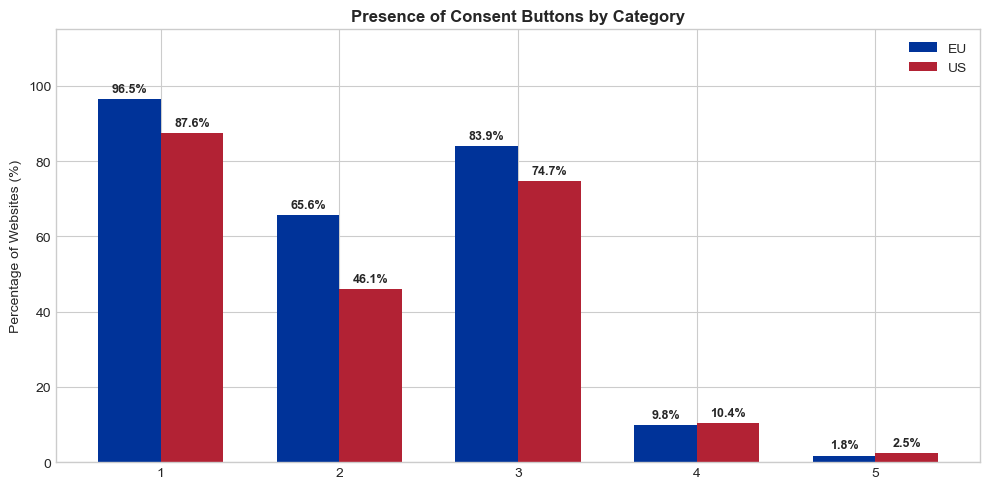

In [19]:
# calculate percentage of websites that have each button
eu_btn_pct = (eu_button_exist.mean() * 100).rename('EU')
us_btn_pct = (us_button_exist.mean() * 100).rename('US')

# combine into one table and fill missing categories with 0
btn_comparison = pd.concat([eu_btn_pct, us_btn_pct], axis=1).fillna(0)

# plot the comparison
categories = btn_comparison.index
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()

# assign the bars to variables so we can loop through them
bars_eu = ax.bar(x - width/2, btn_comparison['EU'], width, label='EU', color=COLORS['EU'])
bars_us = ax.bar(x + width/2, btn_comparison['US'], width, label='US', color=COLORS['US'])

ax.set_ylabel('Percentage of Websites (%)')
ax.set_title('Presence of Consent Buttons by Category', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 115) # Increased from 100 to 115 to leave room for the text labels!
ax.legend()

# add the percentage values on top of the bars
for bars in [bars_eu, bars_us]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', # formats to 1 decimal place with a % sign
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()